In [122]:
from gym import spaces
from gym import Env
import gym 
from typing import Tuple, Optional, List, Union

import PIL.Image
import PIL.ImageDraw
import PIL.Image
from gym import logger, spaces
from PIL import ImageFont
from time import time
%matplotlib inline
import math

import matplotlib.pyplot as plt

from matplotlib import style

from gym.envs.classic_control import utils
import numpy as np
np.set_printoptions(suppress=True)

import json
import random
style.use('dark_background')

from agent import QLearningAgent
from agent import play_and_train

In [123]:
MAX_ROT_SPEED = 150

In [124]:
class DrillingEnv(gym.Env[np.ndarray, Union[int, np.ndarray]]):
  def __init__(self, max_steps):
    high = np.array(
            [
               200
            ],
            dtype=np.int32,
        )
    self.action_space = spaces.Discrete(3)
    self.observation_space = spaces.Box(np.array([0], dtype = np.int32), high, dtype=np.int32)
    self.state = None
    self.steps_beyond_terminated = None
    self.max_steps = max_steps
    self.step_session = 0
  def step(self, action):
    self.step_session += 1
    RPM = self.state
    if action == 0:
      action_rot = 1
    elif action == 1:
     action_rot = -1
    else:
      action_rot = 0
    # 1 -> вправо 
    # 0 -> влево  
    RPM_new = RPM +  action_rot * 2
    self.state = (int(RPM_new))
    RPM_optimal_upper = 120
    RPM_optimal_lower = 105
    terminated = bool(
            RPM_new > MAX_ROT_SPEED * 0.8
            or RPM_new < MAX_ROT_SPEED * 0.7
        )
    if not terminated and RPM_new == RPM  and self.step_session < self.max_steps :
      reward = 15
    elif not terminated and RPM_new != RPM and self.step_session < self.max_steps:
      reward = 10
    elif not terminated and RPM_new == RPM:
      reward = 5
    elif not terminated:
      reward = 2
    elif RPM_new < RPM_optimal_lower:
        if (RPM_optimal_lower - RPM_new) < (RPM_optimal_lower - RPM):
          reward = 1
        else:
          reward = -1
    elif RPM_new > RPM_optimal_upper:
        if (RPM_new  - RPM_optimal_upper) < (RPM - RPM_optimal_upper):
          reward = 1
        else:
          reward = -1
    else:
      reward = -2

    return np.array(self.state, dtype=np.int32), reward, terminated, False
  def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):  
        self.step_session = 0
        RPM = int(np.random.uniform(0, 200))
        self.state = np.array([int(RPM)])
        return np.array(self.state, dtype=np.int32)
  def render(self):
      if self.render_mode is None:
          gym.logger.warn(
              "You are calling render method without specifying any render mode. "
              "You can specify the render_mode at initialization, "
              f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
          )
          return

In [125]:
env = DrillingEnv(25)
state = env.reset()
print(f'Количество действий : {env.action_space.n}')
print(f'Оптимальные обороты: от {MAX_ROT_SPEED * 0.7} до {MAX_ROT_SPEED * 0.8}')
print(f'Начальное состояние: \n \
Обороты : {state[0]}')
s, r, done, _  = env.step(env.action_space.sample())
print(f'Случайное состояние и случайная награда после шага: {s}, {r}')

Количество действий : 3
Оптимальные обороты: от 105.0 до 120.0
Начальное состояние: 
 Обороты : 144
Случайное состояние и случайная награда после шага: 142, 1


### Обучение 

In [126]:
n_actions = 3
agent = QLearningAgent(alpha=0.2, epsilon=0.25, discount=0.99,
                       get_legal_actions=lambda s: range(n_actions))
 # минус этого алгоритма - можно упасть в локальный оптимум
 # фиксим  - правильным подбиранием epsilon

In [127]:
env = DrillingEnv(50)
from tqdm import trange
rewards = []
for i in trange(10_000, position = 0):
  agent.epsilon *= 0.99
  rewards.append(play_and_train(env, agent))
  agent.epsilon *= 0.99
  if i % 1000 == 0 and i != 0:
    print('Средняя награда: ', np.array(rewards).mean())
  if i % 2000 == 0 and i != 0:
    print('epsilon: ', agent.epsilon)  

 10%|█         | 1007/10000 [00:08<02:15, 66.29it/s]

Средняя награда:  5102.382617382617


 20%|██        | 2025/10000 [00:17<01:02, 127.00it/s]

Средняя награда:  5143.735132433783
epsilon:  8.511160651401826e-19


 30%|███       | 3020/10000 [00:26<00:54, 128.72it/s]

Средняя награда:  5155.680439853382


 40%|████      | 4013/10000 [00:36<01:31, 65.21it/s]

Средняя награда:  5159.344913771557
epsilon:  2.9564271251492917e-36


 50%|█████     | 5015/10000 [00:44<00:39, 127.43it/s]

Средняя награда:  5166.217956408718


 60%|██████    | 6025/10000 [00:53<00:30, 128.73it/s]

Средняя награда:  5167.074820863189
epsilon:  1.0269411780964239e-53


 70%|███████   | 7020/10000 [01:04<00:30, 96.72it/s]

Средняя награда:  5169.161976860449


 80%|████████  | 8025/10000 [01:12<00:15, 127.74it/s]

Средняя награда:  5171.713410823647
epsilon:  3.5671712463293677e-71


 90%|█████████ | 9016/10000 [01:21<00:07, 127.76it/s]

Средняя награда:  5173.7860237751365


100%|██████████| 10000/10000 [01:30<00:00, 110.26it/s]


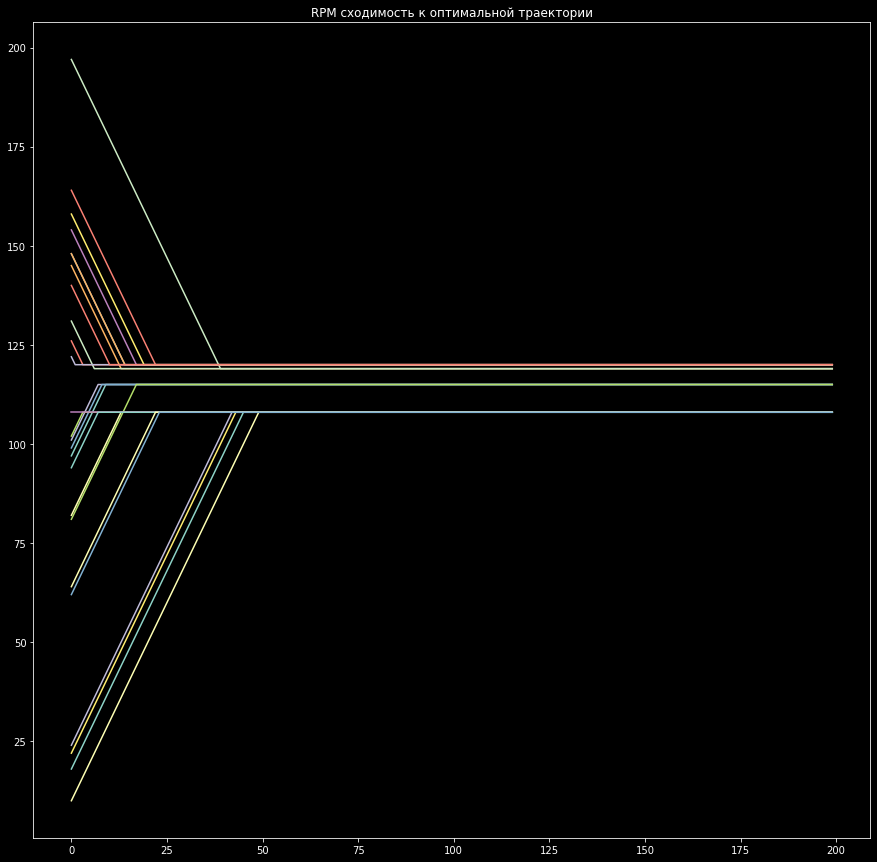

In [128]:
plt.figure(figsize = (15, 15))
for _ in range(25): 
  env = DrillingEnv(50)
  s = env.reset()
  RMP_session = []
  for t in range(200):
      # get agent to pick action given state s.
      a = agent.get_action(s)
      next_s, r, done, _ = env.step(a)
      # train (update) agent for state s
      agent.update(s, a, r, next_s)
      s = next_s
      RMP_session.append(s)
  plt.plot(RMP_session)
  plt.title('RPM сходимость к оптимальной траектории'); 